In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from model import CNNModel, MultiLabelDataset, transform
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

from grokfast import gradfilter_ma, gradfilter_ema

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:" + str(device))

device is:cuda


In [3]:
dataset = MultiLabelDataset(csv_file="..\\generatingSpectograms\\annotation.csv", image_dir="..\\generatingSpectograms\\output\\spectrogram\\", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

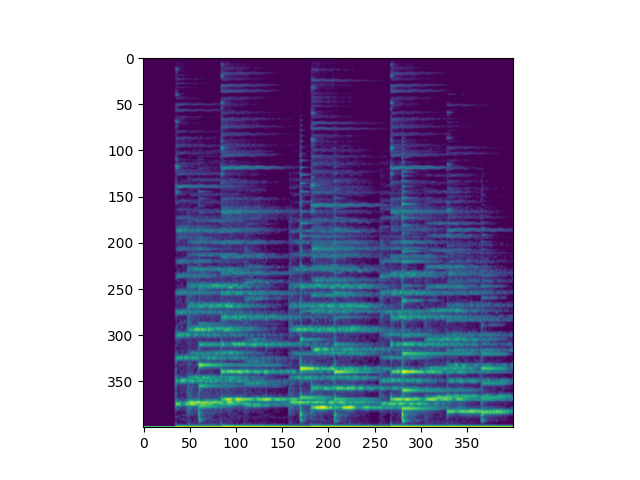

Index(['Acoustic Grand Piano', 'Nylon Acoustic Guitar', 'String Ensemble 1',
       'Piccolo', 'Celesta', 'Acoustic Bass', 'Trumpet', 'Square Wave Lead',
       'Hammond Organ', 'Violin', 'Soprano Sax', 'New Age Pad'],
      dtype='object')
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [4]:
image, labels = dataset[1]
plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.show()
print(dataset.label_columns)
print(labels)

In [5]:
# class counts
df = dataset.annotations
for i in range(1, len(df.columns)):
    print(np.sum(df[df.columns[i]]))

1671
1646
1643
1679
1652
1684
1614
1716
1638
1698
1711
1702


In [6]:
addBias = True
num_classes = dataset.num_classes()
if addBias:
    # Initialize counters for positive and negative samples
    positive_counts = np.zeros(num_classes)
    negative_counts = np.zeros(num_classes)

    # class counts
    df = dataset.annotations
    for i in range(1, len(df.columns)):
        positive_counts[i-1] = np.sum(df[df.columns[i]])
        negative_counts[i-1] = len(df) - positive_counts[i-1]
    # Calculate class weights
    class_weights = negative_counts / (positive_counts + 1e-6) 
    print(f"Class Weights: {class_weights}")

    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
else:
    criterion = nn.BCEWithLogitsLoss()

Class Weights: [3.78755236 3.86026731 3.86914181 3.76474091 3.84261501 3.75059382
 3.95662949 3.66200466 3.88400488 3.7114252  3.67562829 3.70035252]


In [7]:
model = CNNModel(dataset.num_classes()).to(device)
#weights_init(model)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
loss_arr = []
grads = None

In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        #grads = gradfilter_ema(model, grads=grads, alpha=0.98, lamb=2.0)
        optimizer.step()
        running_loss += loss.item()
    
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    loss_arr.append(running_loss/len(train_loader))

Epoch 1/20, Loss: 2.009416556060314
Epoch 2/20, Loss: 0.3045727062225342
Epoch 3/20, Loss: 0.25521117717027664
Epoch 4/20, Loss: 0.16357361000031234
Epoch 5/20, Loss: 0.16435520306229592
Epoch 6/20, Loss: 0.05059941053390503
Epoch 7/20, Loss: 0.03841863570734858
Epoch 8/20, Loss: 0.03617144649848342
Epoch 9/20, Loss: 0.034891926292330025
Epoch 10/20, Loss: 0.031036169743165375


In [29]:
torch.save(model, 'model400x400.pt')

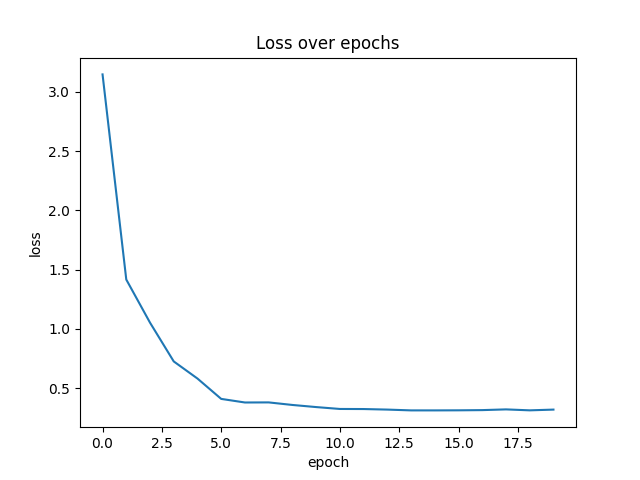

In [28]:
plt.figure()
plt.title("Loss over epochs")
plt.plot(loss_arr)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [27]:
from sklearn.metrics import f1_score

model.eval()
threshold = 0.5

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        # print(outputs)
        
        predicted = (outputs > threshold).float()

        all_labels.append(labels.cpu())
        all_predictions.append(predicted.cpu())

all_labels = torch.cat(all_labels, dim=0).numpy()
all_predictions = torch.cat(all_predictions, dim=0).numpy()

num_labels = all_labels.shape[1]
f1_scores = []

Label 0: F1 Score = 0.82
Label 1: F1 Score = 0.93
Label 2: F1 Score = 0.93
Label 3: F1 Score = 0.97
Label 4: F1 Score = 0.87
Label 5: F1 Score = 0.78
Label 6: F1 Score = 0.90
Label 7: F1 Score = 0.99
Label 8: F1 Score = 0.87
Label 9: F1 Score = 0.97
Label 10: F1 Score = 0.96
Label 11: F1 Score = 1.00


In [35]:
for i in range(num_labels):
    f1 = f1_score(all_labels[:, i], all_predictions[:, i], zero_division=1)
    f1_scores.append(f1)
    print(dataset.label_columns[i] + f':\t\t F1 Score = {f1:.2f}')

Acoustic Grand Piano:		 F1 Score = 0.82
Nylon Acoustic Guitar:		 F1 Score = 0.93
String Ensemble 1:		 F1 Score = 0.93
Piccolo:		 F1 Score = 0.97
Celesta:		 F1 Score = 0.87
Acoustic Bass:		 F1 Score = 0.78
Trumpet:		 F1 Score = 0.90
Square Wave Lead:		 F1 Score = 0.99
Hammond Organ:		 F1 Score = 0.87
Violin:		 F1 Score = 0.97
Soprano Sax:		 F1 Score = 0.96
New Age Pad:		 F1 Score = 1.00
